<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/cnn_style_transfer/src/video_cnn_fast_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read data from [github repo](https://github.com/scardenol/ai_2023/tree/main/cnn_style_transfer) by url and store locally

In [1]:
# Read data from github repo by url
import urllib.request  # the lib that handles the url stuff

# Video
video_url = "https://github.com/scardenol/ai_2023/blob/main/cnn_style_transfer/data/1.%20input%20video/diving.mp4?raw=true"
video_name = "diving.mp4"
input_video = urllib.request.urlretrieve(video_url, video_name) # Store video locally

# Reference style image
image_url = "https://github.com/scardenol/ai_2023/blob/main/cnn_style_transfer/data/2.%20style%20image/Starry-Night-canvas-Vincent-van-Gogh-New-1889.png?raw=true"
image_name = r"Starry-Night-canvas-Vincent-van-Gogh-New-1889.png"
input_image = urllib.request.urlretrieve(image_url, image_name) # Store image locally

## Extract images or frames from video

In [2]:
import cv2
def get_frames(video_name):
  """
  Function to extract images or frames of a locally stored video.
  The frames per second (fps) and duration are automatiaclly detected.
  """
  count = 0
  images = []
  
  cap = cv2.VideoCapture(video_name)
  success,image = cap.read()
  images.append(image)
  cv2.imwrite(f"image{count}.png", image)

  while success:
    count += 1
    cv2.imwrite(f"image{count}.png", image)
    success,image = cap.read()
    images.append(image)
  return images

In [3]:
images = get_frames(video_name)

In [4]:
import tensorflow as tf

def load_img(path_to_img):
  """
  Function to load an image with tensorflow and limit its maximum
  dimension to 512 pixels
  """
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  """
  Function to display an image
  """
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## Load resulting images as tensorflow tensors

In [5]:
tf_style_image = load_img(image_name)
tf_images = []
for count in range(len(images)):
  tf_images.append(load_img(f"image{count}.png"))

## Compare one image with the desired style to transfer

In [6]:
import numpy as np
import matplotlib.pyplot as plt

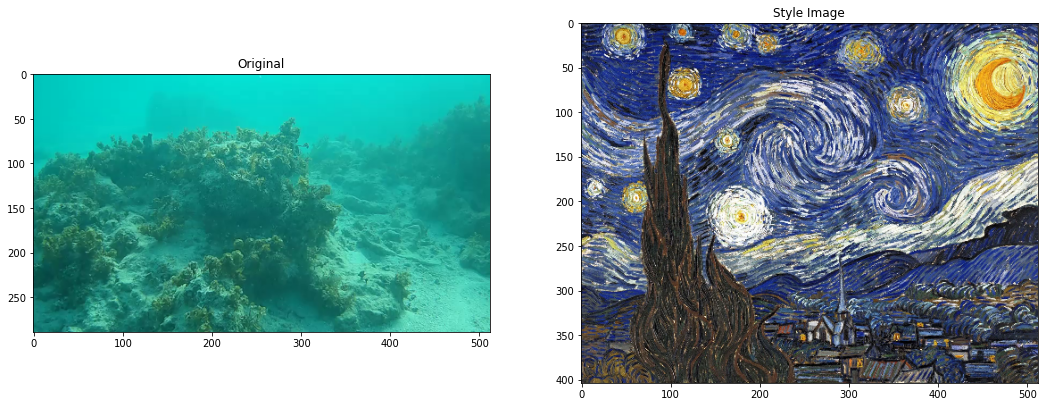

In [7]:
plt.figure(figsize=(18,18))

plt.subplot(1, 2, 1)
imshow(tf_images[0], 'Original')

plt.subplot(1, 2, 2)
imshow(tf_style_image, 'Style Image')

# Test if the fast style transfer doesn't suck

In [8]:
import os
import tensorflow as tf
# Fast style transfer (https://www.tensorflow.org/tutorials/generative/style_transfer)
import tensorflow_hub as hub
# Load compressed models from tensorflow_hub
#os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import numpy as np
import time
import PIL.Image

In [9]:
def transfer_style(images, style_image):
  """
  Function that takes a list of images and applies a fast style transfer using
  tensorflow based on a reference style image. The output is a list of images.
  """
  # Load the fast style transfer model
  hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

  stylized_images = []
  count = 0
  for image in images:
    stylized_images.append(hub_model(tf.constant(image), tf.constant(style_image))[0])
    count += 1
    if count%100 == 0:
      print(f"done {count}")
    
  return stylized_images

In [10]:
stylized_images = transfer_style(tf_images, tf_style_image)

done 100
done 200
done 300
done 400
done 500
done 600
done 700
done 800
done 900
done 1000
done 1100
done 1200


## Compare an original image vs the stylized result

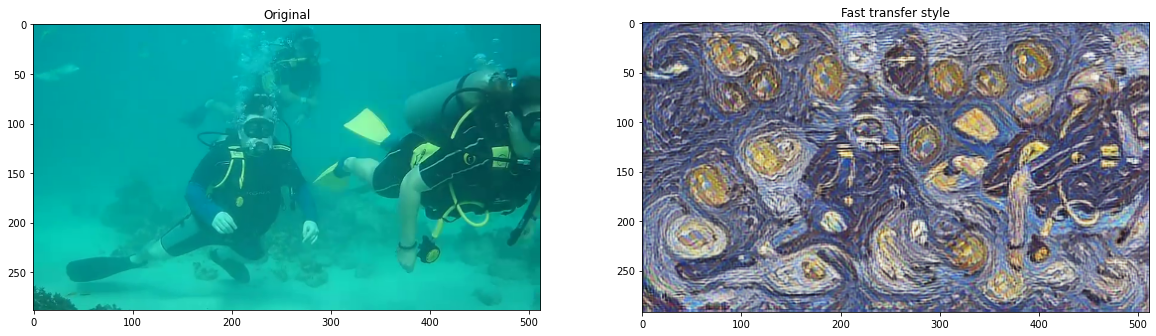

In [11]:
plt.figure(figsize=(20,20))

plt.subplot(1, 2, 1)
imshow(tf_images[900], 'Original')

plt.subplot(1, 2, 2)
imshow(stylized_images[900], 'Fast transfer style')

# Merge stylized images into video

In [12]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return np.squeeze(tensor)

In [13]:
def images_to_video(filename, images, size, video_name):
  cap = cv2.VideoCapture(video_name)
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  (width, length) = size
  size = (length, width)
  out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
  for i in range(len(images)):
    image = tensor_to_image(images[i])
    image = cv2.resize(image, size) # resize image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert back to rgb
    out.write(image)
  out.release()

In [29]:
size = images[0].shape[:2]
output_name = "diving_stylized.mp4"
images_to_video(output_name, stylized_images, size, video_name)

# Extract audio from original video and put it on the stylized video

In [30]:
!pip install ffmpeg moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip

audio = AudioFileClip(video_name)
video = VideoFileClip(output_name)

In [32]:
video.audio = audio

In [33]:
video.write_videofile(f"temp{output_name}")
os.rename(f"temp{output_name}", output_name)

[MoviePy] >>>> Building video tempdiving_stylized.mp4
[MoviePy] Writing audio in tempdiving_stylizedTEMP_MPY_wvf_snd.mp3


100%|██████████| 889/889 [00:01<00:00, 672.71it/s]

[MoviePy] Done.
[MoviePy] Writing video tempdiving_stylized.mp4



100%|█████████▉| 1209/1210 [01:35<00:00, 12.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tempdiving_stylized.mp4 

